<a href="https://colab.research.google.com/github/vgurev/ICMA/blob/master/Force_calcium_test_(Campbell_et_al_2018).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to Campbell et al. 2018 manuscript](https://www.ncbi.nlm.nih.gov/pubmed/30054031)

## Import statements

In [0]:
from scipy.integrate import odeint
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd 
from IPython.display import Image

## Model equations

In [0]:
## ----------------------------
## Thin filament transitions
## ----------------------------
# N_off : binding sites on the thin filament at which myosin heads could not attach too (Inactive state)
# N_on : binding sites on the thin filament which are available for mysoin binding (Active state)
# J_on : the number of sites per unit time switching from N_on to N_off
# J_off : flux of binding sites through the off transition
# k_coop : constant that defines the strength of thin filament cooperativity
# N_overlap - N_on: the number of binding sites that overlap with the thick filament are available to the mysoin heads
# N_on - N_bound: the number of unbound sites (sites that has no myosin bound but are active)

## -----------------------------
## Thick filament transitions 
## -----------------------------
# M_off : the proportion of mysoin heads in the off state
# M_on: the proportion of myosin heads in the on state
# M_FG: the proportion of cross-bridgess attached to actin with spring lengths beween x and x + dx
# J_1: the flux of mysoin heads transition from M_off to M_on state depending on the total force and phosphorylation state of RLCs
# J_2: the flux of myosin heads ino the off state
# J_3: the flux of myosin heads binding to actin
# J_4: the flux of myosin detachement step 


## Scalers for scaling the parameters to have units in nm, nM, ms and N
dnM_M = 1e-9 # convert nM to uM
dPa_kPa = 0.001 # convert from Pa to kPa
dm_nm = 1e9 # convert m to nm
dnm_nm = 1 # convert nm to nm
ds_ms = 1e3 # convert sec to msec
dms_ms = 1 # convert msec to msec
dM_nM = 1e9 # convert molar to nano molar
dnM_nM = 1 # convert nano molar to nano molar

def filament_model(state, t, Ca, p):
    N_off, M_off, *M_FG = state
    N_bound = sum(M_FG)
    N_on = 1 - N_off
    M_on = 1 - M_off - N_bound
    pars = p
    H = pars['H'] ## 1 Phosphorylated RLC, 0 otherwise
    n = pars['n'] ##XB populations evaluated with 0.5 nM resolution over range -10nm <= x <= 10
    k_on = pars['k_on'] / dM_nM / ds_ms #nM-1 ms-1
    N_overlap = pars['N_overlap']
    k_coop = pars['k_coop']
    k_off = pars['k_off'] / ds_ms #ms-1
    k_1 = pars['k_1'] / ds_ms  #ms-1
    k_MLCP = pars['k_MLCP'] / ds_ms  #ms-1
    k_force = pars['k_force'] * dm_nm * dm_nm #N-1 nm2
    k_2 = pars['k_2'] / ds_ms ## ms-1 ??
    k_3 = pars['k_3'] / dnm_nm / ds_ms #nm-1 ms-1
    k_40 = pars['k_40'] / ds_ms  #ms-1
    k_41 = pars['k_41'] / dnm_nm / dnm_nm / dnm_nm / dnm_nm #10 # ?? nm-4
    x_ps = pars['x_ps'] * dnm_nm #nm
    k_cb = pars['k_cb'] / dm_nm  ### N nm-1??
    N_0 = pars['N_0'] / dm_nm / dm_nm ##nm-2
    k_B = pars['k_B'] * dm_nm  # N nm K-1
    T = pars['T'] # K Temperature
    k_p = pars['k_p'] / dm_nm / dm_nm # N nm-2 nm-1
    L_0 = pars['L_0'] * dnm_nm
    L = pars['L'] * dnm_nm
    
    x = np.linspace(-10, 10, n) # Cross-bridge populations were evaluated with 0.5 nm resolution over the range -10 nm < x <10 nm.
    Ca = Ca #nM
    

    
    
    F_passive = k_p * (L - L_0)
        
    F_active = N_0 * k_cb * sum([mfgi * (xi + x_ps) for mfgi, xi in zip(M_FG, x)])
    F_total = F_active + F_passive
    
    
    J_on = k_on * Ca * (N_overlap - N_on) * (1 + k_coop * (N_on / N_overlap))
    J_off = k_off * (N_on - N_bound) * (1 + k_coop * (N_overlap - N_on) / N_overlap)
    
    J_1 = (k_1 + H * k_MLCP) * (1 + k_force * F_total) * M_off
    J_2 = k_2 * M_on

    
    d_N_off = -J_on + J_off
    d_M_off = -J_1 + J_2

    J_3 = np.zeros(n)
    J_4 = np.zeros(n)
    d_M_FG = np.zeros(n)
    
    for ii in range(n):
        J_3[ii] = k_3 * np.exp((-k_cb * x[ii]**2) / (2 * k_B * T)) * M_on * (N_on - N_bound)
        J_4[ii] = (k_40 + k_41 * (x[ii] - x_ps)**4) * M_FG[ii]
        d_M_FG[ii]  = J_3[ii] - J_4[ii]

    
    return [d_N_off, d_M_off] + list(d_M_FG)



## F-Ca test

In [0]:
def f_ca_test(opt_pars = {}):

    pars = {'H' : 1, # H =1 when RCLs are phosphorylated
            'n' : 41 , #XB populations evaluated with 0.5 nM resolution over range -10nm <= x <= 10
            'k_on' : 2.08e7, # M-1 s-1  (page 4 and Table S1)
            'N_overlap' : 1, # 
            'k_coop' : 5.7, # dimensionless (page 4 and Table S1)
            'k_off' : 100, # 100 s-1 (page 4 and Table S1)
            'k_1' : 6.17, # s-1 (Table S1) 
            'k_MLCP' : 1.48, # s-1 (Table S1)
            'k_force' : 1.74e-4, # N-1 m2 (Table S1)
            'k_2' : 200, # s-1 (page 5)
            'k_3' : 7.11, # nm-1 s-1 (Table S1)
            'k_40' : 1.69, # s-1 (Table S1)
            'k_41' : 10, # nm-4 (page 5)
            'x_ps' : 1.4, # nm (Table S1)
            'k_cb' : 0.001, # N m-1 (page 5) 
            'N_0' : 6.9e16, # m-2 (page 3)
            'k_B' : 1.38e-23, # J K-1 (page 3)
            'T' : 310.15, # K (37c page 4)
            'k_p': 28.7, # N m-2 nm-1 (Table S1)
            'L_0':907, # nm (Table S1)
            'L':1900}

    
    if len(pars) > 0:
        for key, value in opt_pars.items():
            if not (key in pars.keys()):
                raise NameError("Parameter %s is not in the model" % (key))
            pars[key] = value

    M_FG_index_offset = 2
    x = np.linspace(-10 , 10, pars['n']) # Cross-bridge populations were evaluated with 0.5 nm resolution over the range -10 nm < x < 10 nm.
    Fmax = []
    ca_list = np.logspace(3, 4, 100) # calcium concentration in the range 10^-3 to 10^-5 nM
    initial_conditions = [1, 1] + [0] * pars['n'] # N_off, M_off, M_FG
    t_start, t_end, n_pts = 0, 5000, 5000
    for Ca in ca_list:
        t = np.linspace(t_start, t_end, n_pts)
        solution = odeint(filament_model, initial_conditions, t, args=(Ca, pars))
        inititial_conditions = solution[-1,:]
     
        F_active = pars['N_0'] / dm_nm / dm_nm * pars['k_cb'] / dm_nm * sum([solution[:, ii + M_FG_index_offset] * (x[ii] + pars['x_ps']) for ii in range(pars['n'])])
        F_passive = pars['k_p'] / dm_nm / dm_nm * (pars['L'] - pars['L_0'])
        Fmax.append(np.max(F_active + F_passive))

    return ca_list, Fmax




# Functions to fit F-Ca

In [0]:
def f_ca_func(ca, h, ca50, fmax, fmin):
    return fmin + fmax * ca**h/ (ca**h + ca50**h)


def f_ca_fit(ca, force):
    popt, pcov = curve_fit(f_ca_func, ca, force, p0 = [7, 1000, max(force), min(force)])
    return popt
  

## An example, simulation +MLCK and two different sarcomere lengths

In [85]:
ca_list1, fmax1 = f_ca_test(opt_pars = {'H': 1, 'N_overlap':0.4}) 
ca_list2, fmax2 = f_ca_test(opt_pars = {'H': 1, 'N_overlap':0.8})

popt1 = f_ca_fit(ca_list1, np.array(fmax1) * dm_nm * dm_nm * dPa_kPa)
popt2 = f_ca_fit(ca_list2, np.array(fmax2) * dm_nm * dm_nm * dPa_kPa)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


(6, 5)

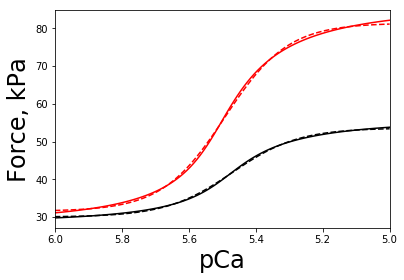

In [86]:
fig, ax = plt.subplots(1, 1)
ax.plot(-np.log10(ca_list1 * dnM_M), np.array(fmax1) * dm_nm * dm_nm * dPa_kPa, 'k-')
ax.plot(-np.log10(ca_list2 * dnM_M), np.array(fmax2) * dm_nm * dm_nm * dPa_kPa, 'r-')

ax.plot(-np.log10(ca_list1 * dnM_M),f_ca_func(ca_list1, *popt1), 'k--')
ax.plot(-np.log10(ca_list2 * dnM_M),f_ca_func(ca_list2, *popt2), 'r--')

ax.set_xlabel('pCa', fontsize  = 24)
ax.set_ylabel('Force, kPa', fontsize = 24)
ax.set_xlim([6, 5])


In [87]:
df = pd.DataFrame([popt1, popt2], columns=['n', 'Ca50', 'fmax', 'fmin'])
df.index = ['SL1', 'SL2']
df['pCa'] = -np.log10(df['Ca50']/1000) + 6
df['color'] = ['black', 'red']
df[['n', 'pCa', 'color']]

,n,pCa,color
SL1,4.390494,5.469914,black
SL2,4.614219,5.491941,red




---

### Longer sarcomere length increases calcium sensisitivity (as in the paper). However, the Hill coefficient slightly increases at longer length (opposite to the paper which shows that longer sarcomere length results in large decrease in the Hill coefficient)

---

